In [1]:
# Import necessary libraries

import datetime as dt
import awkward as ak
import pandas as pd

import pickle
import glob
import re
import h5py
import os

from legend200_data_loader.loader import LegendDataLoader
#print(legend200_data_loader.loader.__file__)
#from legend200_data_loader.metadata import MetadataLoader
from legend200_data_loader.preprocessing import plot_detector_positions
#from legend200_data_loader.preprocessing import get_waveforms_from_raw_tier
from legend200_data_loader.preprocessing import plot_detector_positions_with_data

from legend200_data_loader.config import GLOBAL_PARAM
from legend200_data_loader.utils import file_exists, list_files
from legend200_data_loader.function import filter_metadata
from legendmeta import LegendMetadata
from lgdo import lh5  # Import lh5 for reading .lh5 files


## Step 1: Load Metadata

First set up the SSH agent for accessing the metadata:

In [2]:
import os
from legendmeta import LegendMetadata

# Use SSH agent for authentication
os.environ["SSH_AUTH_SOCK"] = "/tmp/ssh-L2hjBChgyKyB/agent.2106435"

# Now load the metadata
lmeta = LegendMetadata()

# Example to check if it works: Access channel map
channel_id = lmeta.channelmap()['V05261B']['daq']['rawid']
print(f"Channel ID: {channel_id}")

Channel ID: 1104002


In [3]:
# Step 1: Metadata Filtering
detector_type = GLOBAL_PARAM['detector_type']
detectors = filter_metadata(lmeta)

# Check if detectors were found
if not detectors:
    print(f"No detectors found for type: {detector_type}")
else:
    # Remove the 'rawid_lists' key to get only detector entries
    detector_entries = {key: value for key, value in detectors.items() if key != 'rawid_lists'}
    total_detectors = len(detector_entries)
    print(f"Found {total_detectors} HPGE detectors.")

    # Initialize a dictionary to count each detector type
    detector_counts = {'icpc': 0, 'ppc': 0, 'bege': 0, 'coax': 0, 'unknown': 0}

    # Iterate over the filtered detector entries to count each type
    for det_id, det_info in detector_entries.items():
        det_type = det_info.get('type', 'unknown').lower()
        if det_type in detector_counts:
            detector_counts[det_type] += 1
        else:
            detector_counts['unknown'] += 1

    # Print the count of each detector type
    for det_type, count in detector_counts.items():
        if count > 0:
            print(f"{det_type.upper()}: {count}")



        
        
    

Found 101 HPGE detectors.
ICPC: 41
PPC: 26
BEGE: 28
COAX: 6


Metadata for detector rawid_lists not found.


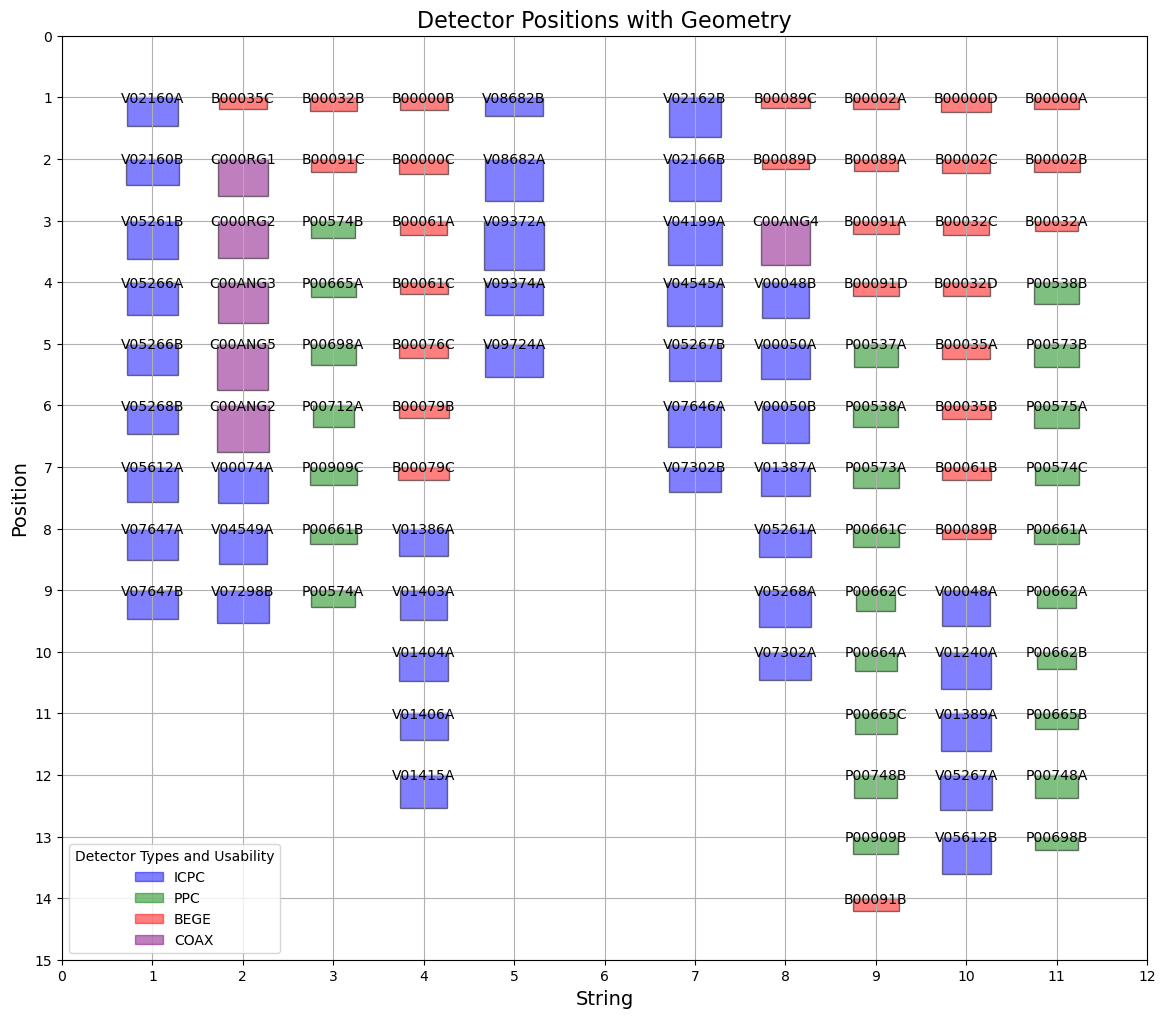

In [4]:
plot_detector_positions(detectors, lmeta)

## Step 2: Load Data

Now that you have the channel_id, you can load the data from your HDF5 files using the LegendDataLoader class in loader.py.

In [5]:
#Initialize an instance of the LegendDataLoader class
data_loader = LegendDataLoader()

During initialization, the loader sets up global parameters (GLOBAL_PARAM) for different directories and subdirectories in the repository, such as:

LEGEND_DATA_DIR: Main directory containing the data.
Various subdirectories (RAW_SUBDIR, PHT_SUBDIR, etc.) for different data tiers.
TYPE: Specifies the type of data (e.g., calibration, background).
Does it open files? No, it does not open any files at this stage. It simply sets up the paths and configuration for future data loading operations.

In [6]:
# Specify the period and run to load data
period = 'p08/'  
# List all available runs in the specified period
available_runs = data_loader.get_runs(period)
print(f"Available runs in {period}: {available_runs}")

Available runs in p08/: ['r000', 'r001', 'r002', 'r003', 'r004', 'r005', 'r006', 'r007', 'r008', 'r009', 'r010', 'r011', 'r012', 'r013', 'r014', 'r015', 'r016']


In [7]:
run = 'r000/'

## Step 3: Filtering for Usable Detectors

#### 1. Load Data Files: Load data files for the specified period and run.
#### 2. Extract Timestamps: Extract timestamps from the filenames to retrieve the metadata.
#### 3. Query Channel Map: Use the timestamp to access the channel map for that specific run's metadata.
#### 4. Filter Detectors: Identify detectors with the 'geds' system and apply usability status filtering (on, ac, off).

This part of the code sets up the stage for data analysis by identifying files and classifying detectors based on their metadata. Actual data analysis (e.g., reading .lh5 files) would involve further steps where the file contents are opened and processed.

Data Type: cal/
Period: p08/
Run: r000/
Using timestamp: 20231002T224302Z from tier: raw_files
Successfully retrieved channel map for timestamp: 20231002T224302Z
Number of usable detectors: 75
Number of 'ac' detectors: 14
Usable detectors in the data by type:
ICPC: 36
PPC: 20
BEGE: 27
COAX: 6


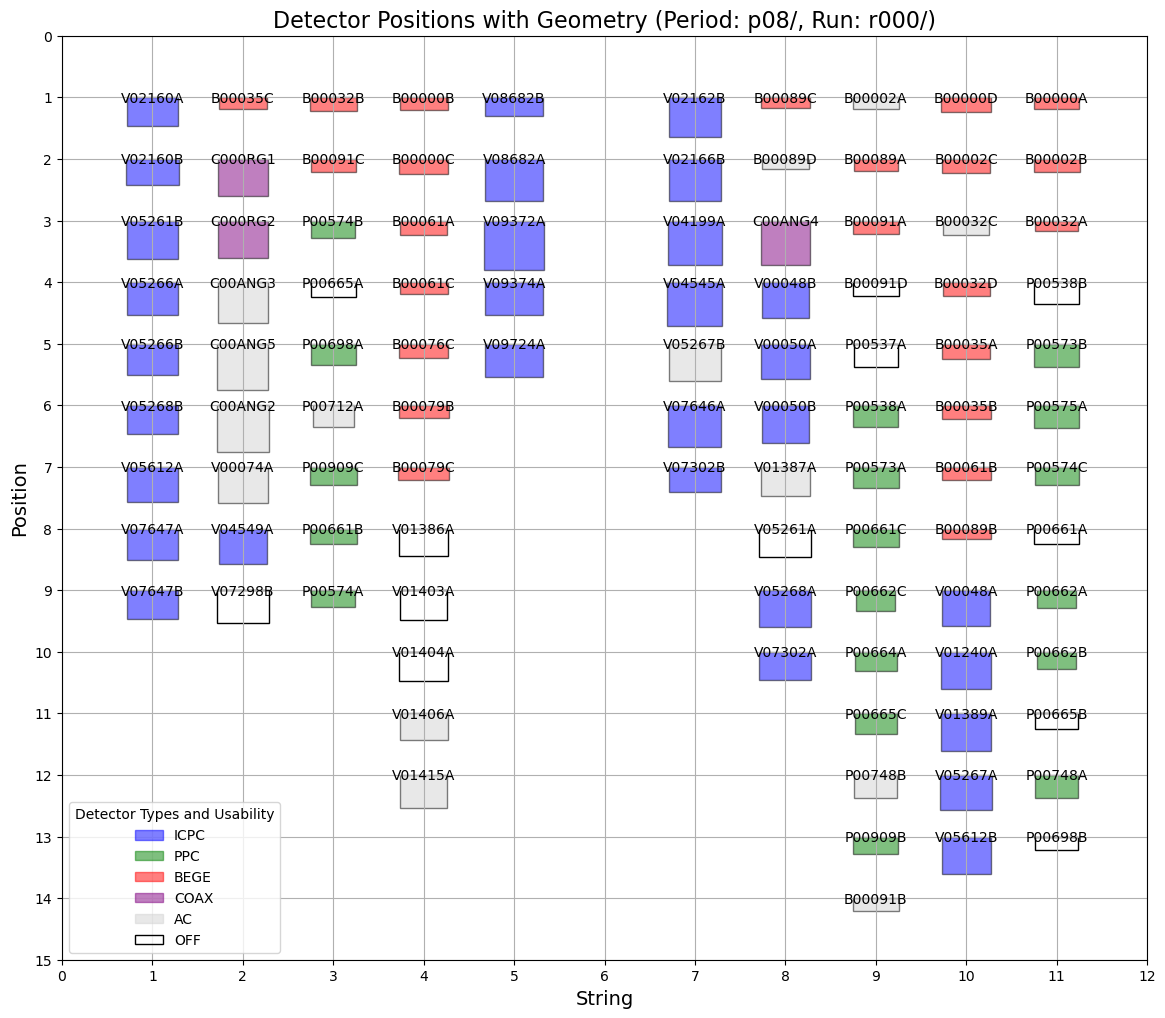

In [8]:
# Load data files for the specified period and run
file_dict = data_loader.load_files(period, run) #loads file paths using the load_files method
#The load_files method:
#Constructs file paths using the provided period and run info
#Searches for files in different tiers (raw_files, pht_files, tcm_files, etc.) using glob.glob.
#Collects the paths of the files found in a dictionary (file_dict) and returns it. 
#It does not load or read the contents of the files at this stage!
#It merely finds and lists the paths of files in different subdirectories for the specified period and run

print(f"Data Type: {data_loader.type}")
print(f"Period: {period}")
print(f"Run: {run}")

# Extract timestamps from the filenames in the specified tier
#this code below processes filenames to extract timestamps
tier_to_check = 'raw_files'
timestamps = []
for file_path in file_dict.get(tier_to_check, []):
    filename = os.path.basename(file_path)
    match = re.search(r'\d{8}T\d{6}Z', filename)
    if match:
        timestamps.append(match.group())

# Use the first timestamp to query the metadata
if timestamps:
    timestamp = timestamps[0]
    print(f"Using timestamp: {timestamp} from tier: {tier_to_check}")
    try:
        channel_map = lmeta.channelmap(timestamp)
        print(f"Successfully retrieved channel map for timestamp: {timestamp}")
    except Exception as e:
        print(f"Error retrieving channel map for timestamp {timestamp}: {e}")
        channel_map = None
else:
    print(f"No valid timestamp found in filenames of tier: {tier_to_check}.")
    channel_map = None

# Filter the usable detectors based on the 'geds' detectors and usability status
usable_detectors = []
ac_detectors = []
off_detectors = []

if channel_map:
    for det_id in detectors:
        # Retrieve analysis info for the detector
        detector_info = channel_map.get(det_id, {})
        analysis_info = detector_info.get('analysis', {})
        usability = analysis_info.get('usability', 'unknown')

        # Print the analysis info for debugging
        #print(f"Detector {det_id} analysis info: {analysis_info}")

        # Apply usability filters
        if usability == 'on':
            usable_detectors.append(det_id)
            #print(f"Added usable detector: {det_id}")
        elif usability == 'ac':
            ac_detectors.append(det_id)
            #print(f"Marked detector {det_id} with usability 'ac' for special plotting.")
        elif usability == 'off':
            off_detectors.append(det_id)
            #print(f"Marked detector {det_id} with usability 'off' for yellow plotting.")
else:
    print("Channel map is not available, skipping detector matching.")

# Count detectors by type for usable detectors
detector_counts = {'icpc': 0, 'ppc': 0, 'bege': 0, 'unknown': 0, 'coax': 0}
for det_id in usable_detectors + ac_detectors:
    det_type = detectors[det_id].get('type', 'unknown').lower()
    detector_counts[det_type] = detector_counts.get(det_type, 0) + 1

# Print the number of usable detectors and their types
print(f"Number of usable detectors: {len(usable_detectors)}")
print(f"Number of 'ac' detectors: {len(ac_detectors)}")
print("Usable detectors in the data by type:")
for det_type, count in detector_counts.items():
    if count > 0:
        print(f"{det_type.upper()}: {count}")

# Plot the usable detectors, handling 'on', 'ac', and 'off' separately
if usable_detectors or ac_detectors or off_detectors:
    plot_detector_positions(usable_detectors, lmeta, period, run, ac_detectors=ac_detectors, off_detectors=off_detectors)
else:
    print("No usable detectors found to plot.")


In [10]:
# Assuming file_dict is already created in your notebook
tier_to_check = 'raw_files'

if tier_to_check in file_dict and file_dict[tier_to_check]:
    raw_file_path = file_dict[tier_to_check][0]  # Get the first file from the specified tier
    print(f"Selected file: {os.path.basename(raw_file_path)}")
else:
    print(f"No raw files found in tier: {tier_to_check}.")


Selected file: l200-p08-r000-cal-20231002T224302Z-tier_raw.lh5


In [11]:
import h5py
import pandas as pd

def lh5_to_dataframe(file_path, channel_name, group_name='raw'):
    """Convert datasets from a specified channel and group in an .lh5 file into a pandas DataFrame."""
    try:
        with h5py.File(file_path, 'r') as f:
            # Construct the full path to the group's datasets
            group_path = f"{channel_name}/{group_name}"
            
            # Check if the specified group exists
            if group_path in f:
                # Extract all scalar datasets within the group
                data_dict = {}
                group = f[group_path]
                for dataset_name, dataset in group.items():
                    if isinstance(dataset, h5py.Dataset) and dataset.shape:  # Only add non-empty datasets
                        data_dict[dataset_name] = dataset[:]

                # Convert the dictionary to a DataFrame
                df = pd.DataFrame(data_dict)
                return df
            else:
                print(f"Group '{group_path}' not found in the file.")
                return None
    except Exception as e:
        print(f"Error reading file {file_path}: {str(e)}")
        return None



# Convert datasets under 'ch1027200/raw' into a DataFrame
channel_name = 'ch1027200'  # Replace with the desired channel name
df = lh5_to_dataframe(raw_file_path, channel_name)

# Display the first few rows of the DataFrame
if df is not None:
    print(df.head())
else:
    print("Failed to create DataFrame.")


   abs_delta_mu_usec  baseline  board_id  channel  crate  daqenergy  deadtime  \
0                847     14988       272      177      1      40834  1.665173   
1                833     14988       272      177      1      40688  1.665173   
2                845     14988       272      177      1      40852  1.665173   
3                842     14988       272      177      1      41128  1.665173   
4                842     14988       272      177      1      40909  1.665173   

   delta_mu_usec  dr_maxticks  dr_start_pps  ...  slot  t_sat_hi  t_sat_lo  \
0            847    249999999             0  ...     0       0.0       0.0   
1            833    249999999             0  ...     0       0.0       0.0   
2            845    249999999             0  ...     0       0.0       0.0   
3            842    249999999             0  ...     0       0.0       0.0   
4            842    249999999             0  ...     0       0.0       0.0   

      timestamp  to_master_sec  to_start_sec

In [12]:
df

,abs_delta_mu_usec,baseline,board_id,channel,crate,daqenergy,deadtime,delta_mu_usec,dr_maxticks,dr_start_pps,...,slot,t_sat_hi,t_sat_lo,timestamp,to_master_sec,to_start_sec,to_start_usec,ts_maxticks,ts_pps,ts_ticks
0,847,14988,272,177,1,40834,1.665173,847,249999999,0,...,0,0.0,0.0,1.696287e+09,1696286584,1,658581,249999999,10,4282
1,833,14988,272,177,1,40688,1.665173,833,249999999,0,...,0,0.0,0.0,1.696287e+09,1696286584,1,658581,249999999,20,4282
2,845,14988,272,177,1,40852,1.665173,845,249999999,0,...,0,0.0,0.0,1.696287e+09,1696286584,1,658581,249999999,30,4282
3,842,14988,272,177,1,41128,1.665173,842,249999999,0,...,0,0.0,0.0,1.696287e+09,1696286584,1,658581,249999999,40,4282
4,842,14988,272,177,1,40909,1.665173,842,249999999,0,...,0,0.0,0.0,1.696287e+09,1696286584,1,658581,249999999,50,4282
5,842,14988,272,177,1,41392,1.665173,842,249999999,0,...,0,0.0,0.0,1.696287e+09,1696286584,1,658581,249999999,60,4282
6,840,14990,272,177,1,40759,1.665173,840,249999999,0,...,0,0.0,0.0,1.696287e+09,1696286584,1,658581,249999999,70,4282
7,838,14989,272,177,1,41229,1.665173,838,249999999,0,...,0,0.0,0.0,1.696287e+09,1696286584,1,658581,249999999,80,4282
8,838,14988,272,177,1,41014,1.665173,838,249999999,0,...,0,0.0,0.0,1.696287e+09,1696286584,1,658581,249999999,90,4282
9,833,14987,272,177,1,40941,1.665173,833,249999999,0,...,0,0.0,0.0,1.696287e+09,1696286584,1,658581,249999999,100,4282


In [13]:
# Open the .lh5 file using h5py
try:
    with h5py.File(raw_file_path, 'r') as f:
        # List all groups and datasets in the file
        print(f"Inspecting file: {raw_file_path}")
        print("Available groups and datasets:")

        def print_structure(name, obj):
            """Helper function to print the structure of the file."""
            if isinstance(obj, h5py.Dataset):
                print(f" - {name}: Dataset, shape={obj.shape}, dtype={obj.dtype}")
            elif isinstance(obj, h5py.Group):
                print(f" - {name}: Group")

        # Visit all items in the file and print their structure
        f.visititems(print_structure)

except Exception as e:
    print(f"Error opening file {raw_file_path}: {str(e)}")


Inspecting file: /dvs_ro/cfs/cdirs/m2676/data/lngs/l200/public/prodenv/prod-blind/ref-raw/generated/tier/raw/cal/p08/r000/l200-p08-r000-cal-20231002T224302Z-tier_raw.lh5
Available groups and datasets:
 - FCConfig: Group
 - FCConfig/adcbits: Dataset, shape=(1,), dtype=int32
 - FCConfig/adccards: Dataset, shape=(1,), dtype=int32
 - FCConfig/blprecision: Dataset, shape=(1,), dtype=int32
 - FCConfig/board_rev: Group
 - FCConfig/board_rev/cumulative_length: Dataset, shape=(1,), dtype=uint32
 - FCConfig/board_rev/flattened_data: Dataset, shape=(32,), dtype=uint8
 - FCConfig/board_uid: Group
 - FCConfig/board_uid/cumulative_length: Dataset, shape=(1,), dtype=uint32
 - FCConfig/board_uid/flattened_data: Dataset, shape=(32,), dtype=uint64
 - FCConfig/ch_board_id: Group
 - FCConfig/ch_board_id/cumulative_length: Dataset, shape=(1,), dtype=uint32
 - FCConfig/ch_board_id/flattened_data: Dataset, shape=(181,), dtype=uint16
 - FCConfig/ch_inputnum: Group
 - FCConfig/ch_inputnum/cumulative_length: Da

In [14]:
# List available attributes and methods in lgdo.lh5
print(dir(lh5))

['DEFAULT_HDF5_SETTINGS', 'LH5Iterator', 'LH5Store', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_serializers', 'annotations', 'core', 'datatype', 'exceptions', 'iterator', 'load_dfs', 'load_nda', 'ls', 'read', 'read_as', 'read_n_rows', 'show', 'store', 'tools', 'utils', 'write']


In [15]:
def inspect_lh5_file(file_path):
    """Inspect the contents of an .lh5 file."""
    try:
        with h5py.File(file_path, 'r') as f:
            # List all groups and datasets in the file
            print(f"Inspecting file: {file_path}")
            print("Available groups/datasets:")
            def print_structure(name, obj):
                if isinstance(obj, h5py.Dataset):
                    print(f" - {name}: Dataset, shape={obj.shape}, dtype={obj.dtype}")
                elif isinstance(obj, h5py.Group):
                    print(f" - {name}: Group")
            
            f.visititems(print_structure)

    except Exception as e:
        print(f"Error inspecting file {file_path}: {str(e)}")




In [16]:
# Extract the raw_files from the file_dict
tier_to_check = 'raw_files'

if tier_to_check in file_dict and file_dict[tier_to_check]:
    raw_files = file_dict[tier_to_check]  # Get the list of raw files from the specified tier
    print(f"Found {len(raw_files)} raw files.")
    
    
    

Found 46 raw files.


In [17]:
def lh5_to_dataframe(file_path, dataset_name):
    """Convert a dataset from an .lh5 file into a pandas DataFrame."""
    try:
        with h5py.File(file_path, 'r') as f:
            # Check if the specified dataset exists
            if dataset_name in f:
                # Extract the dataset
                dataset = f[dataset_name]
                
                # Check if the dataset is a proper array
                if isinstance(dataset, h5py.Dataset):
                    data = dataset[:]
                    # Create a DataFrame from the numpy array
                    df = pd.DataFrame(data)
                    return df
                else:
                    print(f"{dataset_name} is not a valid dataset.")
                    return None
            else:
                print(f"Dataset '{dataset_name}' not found in the file.")
                return None
    except Exception as e:
        print(f"Error reading file {file_path}: {str(e)}")
        return None




In [18]:
# Extract the raw_files from the file_dict
tier_to_check = 'raw_files'

if tier_to_check in file_dict and file_dict[tier_to_check]:
    raw_files = file_dict[tier_to_check]  # Get the list of raw files from the specified tier
    print(f"Found {len(raw_files)} raw files.")
    
    # Sample usage: Inspect the first raw file in the list
    raw_file_path = raw_files[0]
    #inspect_lh5_file(raw_file_path)  # Inspect the file structure to identify available datasets

    # Convert a specific dataset to a DataFrame (replace 'your_dataset_name_here' with the actual dataset name)
    dataset_name = 'your_dataset_name_here'  # Replace this with the dataset name you found during inspection
    df = lh5_to_dataframe(raw_file_path, dataset_name)
    
    if df is not None:
        print(df.head())  # Display the first few rows of the dataframe
else:
    print(f"No raw files found in tier: {tier_to_check}.")

Found 46 raw files.
Dataset 'your_dataset_name_here' not found in the file.
